<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Chain_Reaction_Tackles_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Load the CSV file
import pandas as pd

file_path = '/content/drive/MyDrive/Recruitment/Brøndby 1-1 Nordsjælland.csv'  # adjust if in a folder
df = pd.read_csv(file_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 3: Filter Events
import numpy as np
tackles = df[df["typeId"] == 7].copy()
clearances = df[df["typeId"] == 12].copy()
recoveries = df[df["typeId"] == 49].copy()
passes = df[df["typeId"] == 1].copy()
follow_up_events = pd.concat([clearances, recoveries, passes])

# STEP 4: Chain Reaction Tackle Logic
chain_data = []
for idx, tackle in tackles.iterrows():
    team = tackle["contestantId"]
    start_time = tackle["timeSeconds"]
    end_time = start_time + 10
    chain = follow_up_events[
        (follow_up_events["contestantId"] == team) &
        (follow_up_events["timeSeconds"] > start_time) &
        (follow_up_events["timeSeconds"] <= end_time)
    ]
    chain_length = len(chain)
    is_chain_reaction = chain_length >= 2
    chain_data.append({
        "tackle_id": tackle["id"],
        "team": team,
        "start_time": start_time,
        "chain_length": chain_length,
        "is_chain_reaction": is_chain_reaction
    })

chain_df = pd.DataFrame(chain_data)

# STEP 5: Add Coordinates and Zones
def get_zone(x):
    if x <= 33.3:
        return 'Defensive Third'
    elif x <= 66.6:
        return 'Middle Third'
    else:
        return 'Attacking Third'

tackle_positions = df[df["typeId"] == 7][["id", "x", "y"]].set_index("id")
tackle_positions.columns = ["tackle_x", "tackle_y"]
chain_df = chain_df.merge(tackle_positions, left_on="tackle_id", right_index=True, how="left")
chain_df["tackle_zone"] = chain_df["tackle_x"].apply(get_zone)

# STEP 6: Advanced Metrics
df = df.sort_values(by="timeSeconds").reset_index(drop=True)
chain_df["chain_duration"] = np.nan
chain_df["chain_ends_in_possession"] = False
chain_df["chain_ends_in_attack"] = False
chain_df["avg_time_between_actions"] = np.nan

for i, row in chain_df.iterrows():
    tackle_time = row["start_time"]
    team = row["team"]
    end_time = tackle_time + 10
    chain = df[
        (df["contestantId"] == team) &
        (df["timeSeconds"] > tackle_time) &
        (df["timeSeconds"] <= end_time) &
        (df["typeId"].isin([12, 49, 1]))
    ]

    if not chain.empty:
        chain_df.at[i, "chain_duration"] = chain["timeSeconds"].max() - tackle_time
        if len(chain) > 1:
            chain_df.at[i, "avg_time_between_actions"] = chain["timeSeconds"].diff().mean()

        last_event = chain.iloc[-1]
        if last_event["typeId"] == 1 and last_event["contestantId"] == team:
            chain_df.at[i, "chain_ends_in_possession"] = True

        qualifiers = last_event.filter(like='qualifier').dropna()
        endX = None
        if 'qualifier/140/value' in qualifiers:
            try:
                endX = float(qualifiers['qualifier/140/value'])
            except:
                pass
        if endX is not None and endX > 60:
            chain_df.at[i, "chain_ends_in_attack"] = True

# STEP X: Calculate CRT Value Added per Zone

# Score function for value added
def score_row(row):
    score = 0
    if row["is_chain_reaction"]:
        score += 1
    if row["chain_ends_in_possession"]:
        score += 1
    if row["chain_ends_in_attack"]:
        score += 1
    if row["chain_length"] >= 3:
        score += 1
    return score

# Apply scoring
chain_df["crt_value"] = chain_df.apply(score_row, axis=1)

# Group by zone
zone_values = chain_df.groupby("tackle_zone").agg(
    CRTs=("is_chain_reaction", "sum"),
    Total_Tackles=("tackle_id", "count"),
    Total_CRT_Value=("crt_value", "sum"),
    Avg_CRT_Value=("crt_value", "mean")
).reset_index()

# Sort for easy reading
zone_values = zone_values.sort_values("Avg_CRT_Value", ascending=False)

# Display results
print("🏟️ CRT Value Added by Tackle Zone:\n")
for _, row in zone_values.iterrows():
    print(f"🔹 {row['tackle_zone']}")
    print(f"   - CRTs: {int(row['CRTs'])} / {int(row['Total_Tackles'])} tackles")
    print(f"   - Total CRT Value: {int(row['Total_CRT_Value'])}")
    print(f"   - Avg CRT Value: {round(row['Avg_CRT_Value'], 2)}\n")


# STEP 7: Summary Printout
total_tackles = len(chain_df)
crt_count = chain_df["is_chain_reaction"].sum()
crr = crt_count / total_tackles
avg_len = chain_df[chain_df["is_chain_reaction"]]["chain_length"].mean()
avg_dur = chain_df[chain_df["is_chain_reaction"]]["chain_duration"].mean()
possession_pct = chain_df[chain_df["is_chain_reaction"]]["chain_ends_in_possession"].mean()
attack_pct = chain_df[chain_df["is_chain_reaction"]]["chain_ends_in_attack"].mean()
def_third_pct = (chain_df["tackle_zone"] == "Defensive Third").mean()

print("📊 Chain Reaction Tackle Stats")
print(f"🔢 Total Tackles: {total_tackles}")
print(f"🔗 Chain Reaction Tackles (CRTs): {crt_count}")
print(f"📈 Chain Reaction Rate (CRR): {round(crr * 100)}%")
print(f"📐 Average Chain Length (CRTs only): {round(avg_len, 2)} actions")
print(f"⏱️ Avg Chain Duration (CRTs only): {round(avg_dur, 2)} seconds")
print(f"🎯 CRTs Ending in Possession (%): {round(possession_pct * 100)}%")
print(f"🚀 CRTs Ending in Attack (%): {round(attack_pct * 100)}%")
print(f"🗺️ Tackles in Defensive Third (%): {round(def_third_pct * 100)}%")

# STEP 8: Save to Excel
output_path = '/content/drive/MyDrive/Recruitment/CRT_Analysis_Advanced.xlsx'
chain_df.to_excel(output_path, index=False)
print(f"\n✅ Saved to: {output_path}")

🏟️ CRT Value Added by Tackle Zone:

🔹 Defensive Third
   - CRTs: 10 / 15 tackles
   - Total CRT Value: 28
   - Avg CRT Value: 1.87

🔹 Attacking Third
   - CRTs: 3 / 7 tackles
   - Total CRT Value: 8
   - Avg CRT Value: 1.14

🔹 Middle Third
   - CRTs: 3 / 11 tackles
   - Total CRT Value: 10
   - Avg CRT Value: 0.91

📊 Chain Reaction Tackle Stats
🔢 Total Tackles: 33
🔗 Chain Reaction Tackles (CRTs): 16
📈 Chain Reaction Rate (CRR): 48%
📐 Average Chain Length (CRTs only): 3.06 actions
⏱️ Avg Chain Duration (CRTs only): 6.25 seconds
🎯 CRTs Ending in Possession (%): 100%
🚀 CRTs Ending in Attack (%): 0%
🗺️ Tackles in Defensive Third (%): 45%

✅ Saved to: /content/drive/MyDrive/Recruitment/CRT_Analysis_Advanced.xlsx


✅ Saved flow map to: /content/drive/MyDrive/CRT_FlowMap_EconomistStyle.png


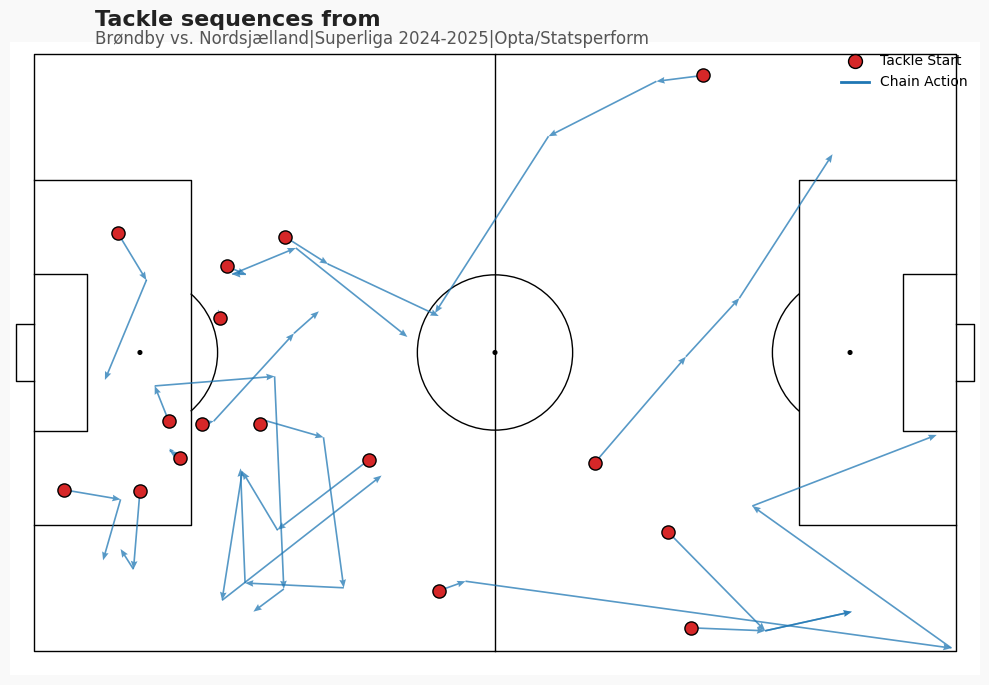

In [ ]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Setup the pitch
pitch = Pitch(
    pitch_type='opta',
    pitch_color='white',
    line_color='black',
    linewidth=1,
    goal_type='box',
    axis=False,
    label=False,
    pad_top=2
)

fig, ax = pitch.draw(figsize=(10, 7))
fig.set_facecolor('#f9f9f9')

# Adjust layout to allow more space at the very top
fig.subplots_adjust(top=0.88)

# Move title and subtitle higher
fig.text(0.1, 0.975, "Tackle sequences from ", fontsize=16, weight='bold', color='#222222')
fig.text(0.1, 0.95, "Brøndby vs. Nordsjælland|Superliga 2024-2025|Opta/Statsperform", fontsize=12, color='#555555')


# Plot sample CRTs
crt_ids = chain_df[chain_df["is_chain_reaction"]].head(20)["tackle_id"].values

for tackle_id in crt_ids:
    row = chain_df[chain_df["tackle_id"] == tackle_id].iloc[0]
    start_time = row["start_time"]
    team = row["team"]

    # Chain events
    chain = df[
        (df["contestantId"] == team) &
        (df["timeSeconds"] > start_time) &
        (df["timeSeconds"] <= start_time + 10) &
        (df["typeId"].isin([12, 49, 1]))
    ].copy()

    if not chain.empty:
        x_prev = row["tackle_x"]
        y_prev = row["tackle_y"]

        # Tackle marker
        pitch.scatter(x_prev, y_prev, ax=ax, s=90, color='#D62728', edgecolors='black', zorder=3)

        # Action arrows
        for _, ev in chain.iterrows():
            x = ev.get("x", np.nan)
            y = ev.get("y", np.nan)
            if pd.notnull(x) and pd.notnull(y):
                pitch.arrows(
                    x_prev, y_prev, x, y,
                    ax=ax,
                    color='#1f77b4',
                    width=1.2,
                    headwidth=4,
                    headlength=5,
                    alpha=0.75,
                    zorder=2
                )
                x_prev, y_prev = x, y

# Add custom legend manually
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Tackle Start',
           markerfacecolor='#D62728', markeredgecolor='black', markersize=10),
    Line2D([0], [0], color='#1f77b4', lw=2, label='Chain Action')
]

ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=10)

# Save figure
fig_path = '/content/drive/MyDrive/CRT_FlowMap_EconomistStyle.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
print(f"✅ Saved flow map to: {fig_path}")

plt.show()


In [ ]:
pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 3.5 MB/s eta 0:00:00


✅ Saved smart aerial duel map to: /content/drive/MyDrive/Aerial_Duel_Target_Zones_Smart.png


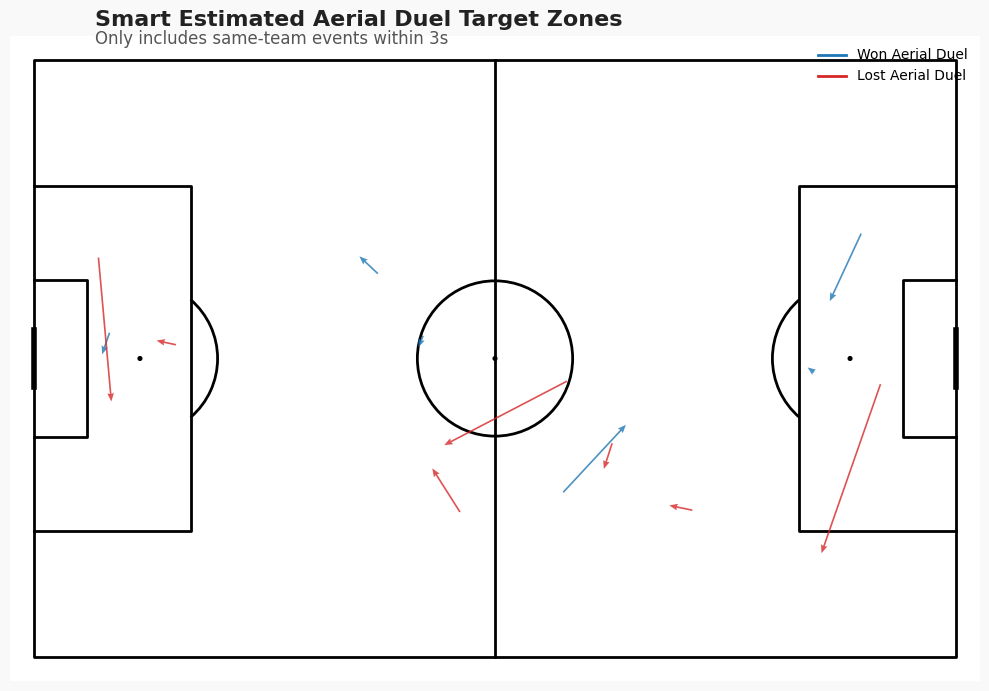

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.lines import Line2D

# Sort chronologically and calculate seconds
df = df.sort_values(by=["timeMin", "timeSec"]).reset_index(drop=True)
df["timeSeconds"] = df["timeMin"] * 60 + df["timeSec"]

# Filter aerial duels
aerials = df[df["typeId"] == 44].copy()

# Estimate landing spots using smarter logic
aerials_smart_estimation = []

for idx, aerial in aerials.iterrows():
    aerial_index = df[df["id"] == aerial["id"]].index
    if aerial_index.empty:
        continue
    current_index = aerial_index[0]
    team = aerial["contestantId"]
    aerial_time = aerial["timeSeconds"]

    # Look ahead max 3 next events
    for i in range(current_index + 1, min(current_index + 4, len(df))):
        next_event = df.iloc[i]
        if (
            next_event["contestantId"] == team and
            0 < next_event["timeSeconds"] - aerial_time <= 5 and
            pd.notnull(next_event.get("x", None)) and
            pd.notnull(next_event.get("y", None))
        ):
            aerials_smart_estimation.append({
                "id": aerial["id"],
                "contestantId": team,
                "outcome": aerial["outcome"],
                "duel_x": aerial["x"],
                "duel_y": aerial["y"],
                "est_endX": next_event["x"],
                "est_endY": next_event["y"],
                "time_diff": next_event["timeSeconds"] - aerial_time
            })
            break

# Create DataFrame
aerials_estimated = pd.DataFrame(aerials_smart_estimation)

# Calculate distance between duel and estimated landing
aerials_estimated["distance"] = np.sqrt(
    (aerials_estimated["est_endX"] - aerials_estimated["duel_x"]) ** 2 +
    (aerials_estimated["est_endY"] - aerials_estimated["duel_y"]) ** 2
)

# --- Plotting ---
pitch = Pitch(pitch_type='opta', pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))
fig.set_facecolor('#f9f9f9')
fig.subplots_adjust(top=0.88)

# Titles
fig.text(0.1, 0.975, "Smart Estimated Aerial Duel Target Zones", fontsize=16, weight='bold', color='#222222')
fig.text(0.1, 0.95, "Only includes same-team events within 3s", fontsize=12, color='#555555')

# Arrows: duel → estimated landing
for _, row in aerials_estimated.iterrows():
    color = '#1f77b4' if row['outcome'] == 1 else '#d62728'
    pitch.arrows(
        row['duel_x'], row['duel_y'],
        row['est_endX'], row['est_endY'],
        ax=ax,
        color=color,
        width=1.2,
        headwidth=4,
        headlength=5,
        alpha=0.8,
        zorder=2
    )

# Legend
legend_elements = [
    Line2D([0], [0], color='#1f77b4', lw=2, label='Won Aerial Duel'),
    Line2D([0], [0], color='#d62728', lw=2, label='Lost Aerial Duel')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

# Save to Google Drive
fig_path = '/content/drive/MyDrive/Aerial_Duel_Target_Zones_Smart.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
print(f"✅ Saved smart aerial duel map to: {fig_path}")

plt.show()


In [23]:
pip install mplsoccer

✅ Saved map to: /content/drive/MyDrive/Nordsjaelland_Aerial_Target_Map.png


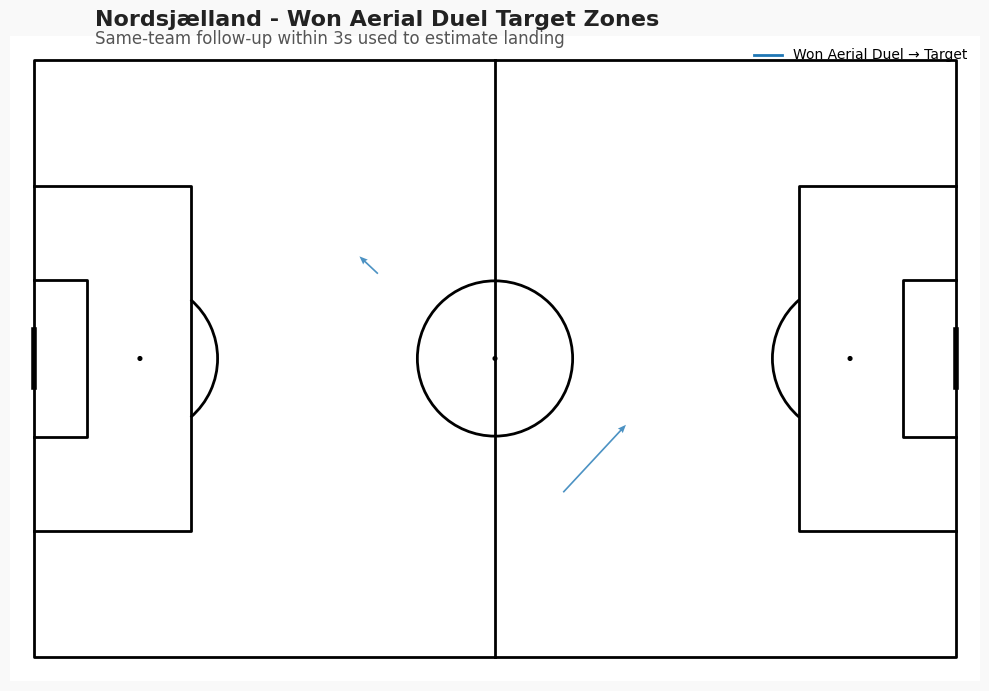

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.lines import Line2D

# Load your CSV
# Sort and calculate time in seconds
df = df.sort_values(by=["timeMin", "timeSec"]).reset_index(drop=True)
df["timeSeconds"] = df["timeMin"] * 60 + df["timeSec"]

# Nordsjælland team ID
team_id = '77tfx9me4aaqhzv78bmgsy9bg'

# Filter successful aerials by Nordsjælland
aerials = df[
    (df["typeId"] == 44) &
    (df["contestantId"] == team_id) &
    (df["outcome"] == 1)
].copy()

# Smart landing estimation (next same-team event within 3s)
aerials_smart_estimation = []
for idx, aerial in aerials.iterrows():
    aerial_index = df[df["id"] == aerial["id"]].index
    if aerial_index.empty:
        continue
    current_index = aerial_index[0]
    aerial_time = aerial["timeSeconds"]
    for i in range(current_index + 1, min(current_index + 4, len(df))):
        next_event = df.iloc[i]
        if (
            next_event["contestantId"] == team_id and
            0 < next_event["timeSeconds"] - aerial_time <= 3 and
            pd.notnull(next_event.get("x")) and
            pd.notnull(next_event.get("y"))
        ):
            aerials_smart_estimation.append({
                "id": aerial["id"],
                "duel_x": aerial["x"],
                "duel_y": aerial["y"],
                "est_endX": next_event["x"],
                "est_endY": next_event["y"],
                "time_diff": next_event["timeSeconds"] - aerial_time
            })
            break

# Create DataFrame
aerials_estimated = pd.DataFrame(aerials_smart_estimation)

# Plotting with mplsoccer
pitch = Pitch(pitch_type='opta', pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))
fig.set_facecolor('#f9f9f9')
fig.subplots_adjust(top=0.88)

fig.text(0.1, 0.975, "Nordsjælland - Won Aerial Duel Target Zones", fontsize=16, weight='bold', color='#222222')
fig.text(0.1, 0.95, "Same-team follow-up within 3s used to estimate landing", fontsize=12, color='#555555')

for _, row in aerials_estimated.iterrows():
    pitch.arrows(
        row['duel_x'], row['duel_y'],
        row['est_endX'], row['est_endY'],
        ax=ax,
        color='#1f77b4',
        width=1.2,
        headwidth=4,
        headlength=5,
        alpha=0.8,
        zorder=2
    )

legend_elements = [
    Line2D([0], [0], color='#1f77b4', lw=2, label='Won Aerial Duel → Target')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

# Save figure
fig_path = '/content/drive/MyDrive/Nordsjaelland_Aerial_Target_Map.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
print(f"✅ Saved map to: {fig_path}")

plt.show()
